In [1]:
!pip install torch 


In [2]:
import pandas as pd
import s3fs 
s3_path = 's3://data-processing1/Aggregated_Data.csv'
df = pd.read_csv(s3_path)
print(df.info())
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20982154 entries, 0 to 20982153
Data columns (total 15 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   _id          object
 1   Dt           object
 2   Sta          int64 
 3   EqN          int64 
 4   Line         int64 
 5   Tag          int64 
 6   St           int64 
 7   hour         int64 
 8   day          int64 
 9   month        int64 
 10  year         int64 
 11  day_of_week  int64 
 12  is_weekend   int64 
 13  weekday      int64 
 14  Hour         object
dtypes: int64(12), object(3)
memory usage: 2.3+ GB
None


,_id,Dt,Sta,EqN,Line,Tag,St,hour,day,month,year,day_of_week,is_weekend,weekday,Hour
0,63b9225c1f70e5b6d8636750,2020-01-01 00:00:35+00:00,207,1200350,7,7001,1,0,1,1,2020,2,0,2,2020-01-01 00:00:00+00:00
1,63b9225c1f70e5b6d8636751,2020-01-01 00:00:35+00:00,207,1200350,7,7001,0,0,1,1,2020,2,0,2,2020-01-01 00:00:00+00:00
2,63b9225c1f70e5b6d8636768,2020-01-01 00:00:37+00:00,207,282875,7,22005,0,0,1,1,2020,2,0,2,2020-01-01 00:00:00+00:00
3,63b9225c1f70e5b6d8636769,2020-01-01 00:00:39+00:00,207,282875,7,22005,0,0,1,1,2020,2,0,2,2020-01-01 00:00:00+00:00
4,63b9225c1f70e5b6d863676a,2020-01-01 00:00:53+00:00,207,282875,7,22005,1,0,1,1,2020,2,0,2,2020-01-01 00:00:00+00:00


Epoch 0/100, Loss: 0.0006218089865190753
Epoch 10/100, Loss: 0.00025875753525767887
Epoch 20/100, Loss: 0.0002067198411645049
Epoch 30/100, Loss: 0.00018064480218527024
Epoch 40/100, Loss: 0.00016305902279869076
Epoch 50/100, Loss: 0.00015394063611460124
Epoch 60/100, Loss: 0.00014735053837934434
Epoch 70/100, Loss: 0.00013627897925029434
Epoch 80/100, Loss: 0.00012885052906096375
Epoch 90/100, Loss: 0.00012549458221136384
Test Loss: 2.9604679567470598e-05
Test predictions saved to test_predictions.csv


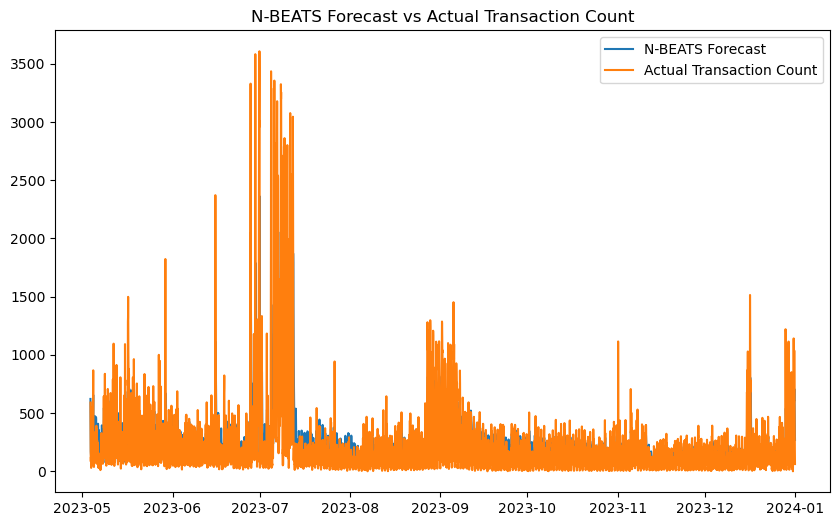

Mean Squared Error: 47943.933320166856
Mean Absolute Error: 100.06411645944786
R-Squared: 0.620721819018957
Model saved to nbeats_model.pth
Scaler saved to newscaler.save


In [24]:
import pandas as pd
import numpy as np
import torch
import joblib
import torch.nn as nn
import torch.optim as optim
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

# Load Dataset
df = pd.read_csv(r's3://data-processing1/Aggregated_Data.csv')  # Use your dataset

# Data Preprocessing
df['Dt'] = pd.to_datetime(df['Dt'], errors='coerce')

# Drop rows with invalid dates if needed
df = df.dropna(subset=['Dt'])

# Set the index to the date column
df.set_index('Dt', inplace=True)

# Aggregating the Transaction Count at Hourly Level
hourly_transaction = df.resample('H').size()  # Hourly transaction count

# Check if hourly_transaction is empty
if hourly_transaction.empty:
    raise ValueError("No data available after resampling.")

# Feature Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(hourly_transaction.values.reshape(-1, 1))

# Hyperparameters
LOOKBACK = 1200  # Backcast horizon (input sequence length)
BATCH_SIZE = 64
EPOCHS = 100
LEARNING_RATE = 0.00001
DROPOUT_RATE = 0.2  # Dropout rate

# Prepare the data for training
def create_sequences(data, lookback):
    x, y = [], []
    for i in range(len(data) - lookback):
        x.append(data[i : i + lookback])
        y.append(data[i + lookback])  # Predicting the next hour
    return np.array(x), np.array(y)

# Split the dataset into training and testing
split_idx = int(len(scaled_data) * 0.8)
train_series, test_series = scaled_data[:split_idx], scaled_data[split_idx:]

# Create sequences for training and testing
X_train, y_train = create_sequences(train_series, LOOKBACK)
X_test, y_test = create_sequences(test_series, LOOKBACK)

# Convert to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader for batching
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Updated N-BEATS Model Definition with Dropout
class NBeatsModel(nn.Module):
    def __init__(self, input_size, hidden_dim=256, dropout_rate=0.2):
        super(NBeatsModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.dropout1 = nn.Dropout(dropout_rate)  # Dropout layer after first hidden layer
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.dropout2 = nn.Dropout(dropout_rate)  # Dropout layer after second hidden layer
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)  # Additional hidden layer
        self.dropout3 = nn.Dropout(dropout_rate)  # Dropout layer after third hidden layer
        self.fc4 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input: [batch_size, LOOKBACK]
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)  # Apply dropout
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)  # Apply dropout
        x = torch.relu(self.fc3(x))  # Apply ReLU activation to the additional hidden layer
        x = self.dropout3(x)  # Apply dropout
        forecast = self.fc4(x)
        return forecast

# Model, loss function, and optimizer with weight decay
nbeats_model = NBeatsModel(input_size=LOOKBACK)
loss_fn = nn.MSELoss()
weight_decay = 0.0001  # L2 regularization factor
optimizer = optim.Adam(nbeats_model.parameters(), lr=LEARNING_RATE, weight_decay=weight_decay)

# Training loop
for epoch in range(EPOCHS):
    nbeats_model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()

        # Forward pass
        forecast = nbeats_model(X_batch)

        # Compute the loss
        loss = loss_fn(forecast, y_batch.view(-1, 1))
        running_loss += loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}/{EPOCHS}, Loss: {running_loss/len(train_loader)}')

# Testing the model
nbeats_model.eval()
test_loss = 0.0
predictions = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        forecast = nbeats_model(X_batch)
        test_loss += loss_fn(forecast, y_batch.view(-1, 1)).item()
        predictions.append(forecast)

# Calculate the test loss
print(f'Test Loss: {test_loss/len(test_loader)}')

# Convert predictions back to original scale
predictions = torch.cat(predictions, dim=0).cpu().tolist()
predictions_rescaled = scaler.inverse_transform(predictions)

# Actual values in the test set
actual_rescaled = scaler.inverse_transform(test_series[-len(predictions_rescaled):])

# Create a DataFrame to store test predictions with timestamps
test_timestamps = hourly_transaction.index[-len(predictions_rescaled):]  # Get timestamps from the test set
test_predictions_df = pd.DataFrame({
    'Dt': test_timestamps,  # Timestamps
    'Predicted_Transaction_Count': predictions_rescaled.flatten()  # Forecasted values
})

# Save the test predictions to CSV
test_predictions_path = r'test_predictions.csv'
test_predictions_df.to_csv(test_predictions_path, index=False)
print(f"Test predictions saved to {test_predictions_path}")

# Plotting the forecast vs actual values
plt.figure(figsize=(10, 6))
plt.plot(hourly_transaction.index[-len(predictions_rescaled):], predictions_rescaled, label='N-BEATS Forecast')
plt.plot(hourly_transaction.index[-len(actual_rescaled):], actual_rescaled, label='Actual Transaction Count')
plt.title("N-BEATS Forecast vs Actual Transaction Count")
plt.legend()
plt.show()

# Evaluate the model
mse = mean_squared_error(actual_rescaled, predictions_rescaled)
mae = mean_absolute_error(actual_rescaled, predictions_rescaled)
r2 = r2_score(actual_rescaled, predictions_rescaled)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-Squared: {r2}")

# Save the trained model
model_path = r'nbeats_model.pth'
torch.save(nbeats_model.state_dict(), model_path)
print(f'Model saved to {model_path}')

# Save the scaler
scaler_path = r'newscaler.save'
joblib.dump(scaler, scaler_path)
print(f'Scaler saved to {scaler_path}')


Confusion Matrix:
[[3504  658]
 [ 312 1339]]
Accuracy: 0.8331
Error Rate: 0.1669
F1 Score: 0.7341


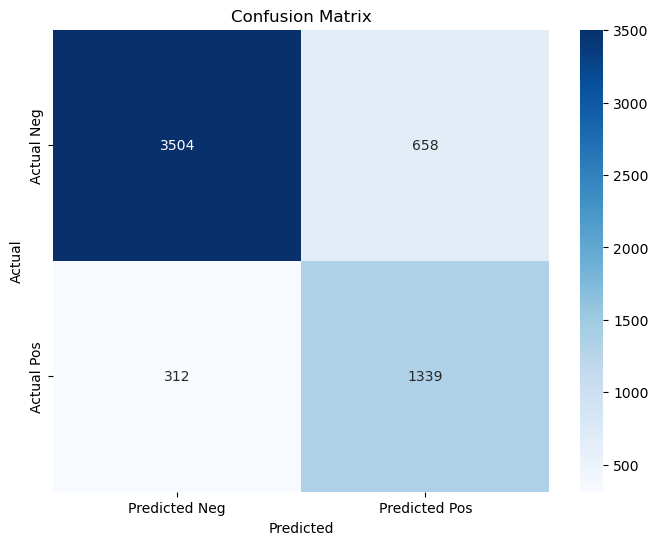

In [25]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import seaborn as sns

# Define a threshold (e.g., mean of actual values)
threshold = np.mean(actual_rescaled)

# Generate binary labels based on the threshold
y_true = (actual_rescaled > threshold).astype(int)
y_pred = (predictions_rescaled > threshold).astype(int)

# Create confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Calculate accuracy, error rate, and F1 score
accuracy = accuracy_score(y_true, y_pred)
error_rate = 1 - accuracy
f1 = f1_score(y_true, y_pred)

# Display results 
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Error Rate: {error_rate:.4f}")
print(f"F1 Score: {f1:.4f}")

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Neg', 'Predicted Pos'], yticklabels=['Actual Neg', 'Actual Pos'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


In [28]:
import pandas as pd
import numpy as np
import joblib
import torch
from datetime import timedelta, datetime
import torch.nn as nn

# Hyperparameters
LOOKBACK_WINDOWS = [120]  # Define multiple lookback windows
LOOKBACK = 1200  # Ensure LOOKBACK is defined

# Load Dataset
df = pd.read_csv(r's3://data-processing1/Aggregated_Data.csv')  # Use your dataset
print("Data shape after loading:", df.shape)  # Check data shape

# Check the contents of the 'Dt' column
print("Unique values in 'Dt' column before conversion:")
print(df['Dt'].unique())

# Data Preprocessing
df['Dt'] = pd.to_datetime(df['Dt'], errors='coerce')

# Check for NaT values after conversion
print("Number of NaT values in 'Dt' column after conversion:", df['Dt'].isna().sum())
df = df.dropna(subset=['Dt'])  # Drop invalid dates if any
df.set_index('Dt', inplace=True)  # Set the date as index

# Print first few rows and date range
print("First few rows of the original DataFrame after dropping NaT:")
print(df.head())
print("Date range of the original DataFrame:")
print(df.index.min(), "to", df.index.max())

# Aggregating the Transaction Count at Hourly Level
hourly_transaction = df.resample('H').size()  # Hourly transaction count
print("Hourly transaction count shape:", hourly_transaction.shape)  # Check the shape after resampling
print("Hourly transaction counts (first 10 entries):")
print(hourly_transaction.head(10))  # Print the first 10 counts

# Updated N-BEATS Model Definition with Dropout
class NBeatsModel(nn.Module):
    def __init__(self, input_size, hidden_dim=256, dropout_rate=0.2):
        super(NBeatsModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.dropout1 = nn.Dropout(dropout_rate)  # Dropout layer after first hidden layer
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.dropout2 = nn.Dropout(dropout_rate)  # Dropout layer after second hidden layer
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)  # Additional hidden layer
        self.dropout3 = nn.Dropout(dropout_rate)  # Dropout layer after third hidden layer
        self.fc4 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input: [batch_size, LOOKBACK]
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)  # Apply dropout
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)  # Apply dropout
        x = torch.relu(self.fc3(x))  # Apply ReLU activation to the additional hidden layer
        x = self.dropout3(x)  # Apply dropout
        forecast = self.fc4(x)
        return forecast

# Function to create sequences for future prediction with multiple lookback windows
def prepare_data_for_prediction(hourly_transactions, lookback_windows, scaler):
    window_data = []
    for lookback in lookback_windows:
        if len(hourly_transactions) < lookback:
            raise ValueError(f"Not enough data for lookback of {lookback}.")
        window_data.append(hourly_transactions[-lookback:].values)

    # Scale the data for each window
    window_data_scaled = [scaler.transform(data.reshape(-1, 1)) for data in window_data]

    # Concatenate all the scaled lookback windows
    X_input = np.concatenate(window_data_scaled, axis=0).reshape(1, -1)  # Shape: [1, sum(LOOKBACK_WINDOWS)]
    return torch.tensor(X_input, dtype=torch.float32)

# Function to filter forecast DataFrame for hours between 05:00:00 and 23:00:00
def filter_by_hour_range(forecast_df, start_hour=0, end_hour=23):
    forecast_df['Hour'] = forecast_df['Dt'].dt.hour
    filtered_df = forecast_df[(forecast_df['Hour'] >= start_hour) & (forecast_df['Hour'] <= end_hour)]
    filtered_df = filtered_df.drop(columns=['Hour'])
    return filtered_df

# Function to forecast future transactions between start and end dates
def forecast_future_transactions(model_path, scaler_path, hourly_transaction, start_date, end_date):
    # Ensure start_date and end_date are in the correct format
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    # Calculate the number of hours between start_date and end_date
    num_hours = int((end_date - start_date).total_seconds() // 3600)
    if num_hours <= 0:
        raise ValueError("End date must be after start date.")

    # Load the scaler
    scaler = joblib.load(scaler_path)
    print("Scaler successfully loaded.")  # Verify if the scaler loads without issues

    # Get the most recent data to use as input
    recent_data = hourly_transaction[-LOOKBACK:].values
    if len(recent_data) < LOOKBACK:
        raise ValueError("Not enough recent data to create the input sequence.")

    scaled_recent_data = scaler.transform(recent_data.reshape(-1, 1))

    # Create a sequence for forecasting
    X_input = torch.tensor(scaled_recent_data[-LOOKBACK:].reshape(1, -1), dtype=torch.float32)

    # Generate future predictions
    future_dates = pd.date_range(start=start_date, periods=num_hours, freq='H')
    future_predictions = []

    # Load the model
    loaded_model = NBeatsModel(input_size=LOOKBACK)
    loaded_model.load_state_dict(torch.load(model_path))
    loaded_model.eval()

    for _ in range(num_hours):
        # Forecast the next hour
        with torch.no_grad():
            forecast = loaded_model(X_input).item()

        # Save the prediction
        future_predictions.append(forecast)

        # Update the input sequence for the next forecast
        hourly_transaction = pd.concat([hourly_transaction, pd.Series([forecast])]).head(LOOKBACK)
        X_input = torch.cat([X_input[:, 1:], torch.tensor([[forecast]])], dim=1)

    # Rescale predictions back to original scale
    future_predictions_rescaled = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

    # Create a DataFrame to store the results
    forecast_df = pd.DataFrame({
        'Dt': future_dates,
        'Predicted_Transaction_Count': future_predictions_rescaled.flatten()
    })

    # Save the forecast to CSV
    forecast_output_path = r'future_forecasts.csv'
    forecast_df.to_csv(forecast_output_path, index=False)
    print(f"Future forecasts saved to {forecast_output_path}")

    return forecast_df

# Example usage
model_path = r'nbeats_model.pth'
scaler_path = r'newscaler.save'

# Input start and end dates for future prediction
start_date = '2024-10-05 00:00:00'
end_date = '2024-10-30 23:00:00'

# Predict future transaction counts
try:
    forecast_df = forecast_future_transactions(model_path, scaler_path, hourly_transaction, start_date, end_date)
    # Print the filtered DataFrame
    print(forecast_df.head())
    
    # Save the filtered future predictions to CSV (optional)
    future_predictions_path = r'future_predictions_filtered2.csv'
    forecast_df.to_csv(future_predictions_path, index=False)
    print(f"Filtered predictions saved to {future_predictions_path}")
except ValueError as e:
    print("Error during forecasting:", e)


Data shape after loading: (20982154, 15)
Unique values in 'Dt' column before conversion:
['2020-01-01 00:00:35+00:00' '2020-01-01 00:00:37+00:00'
 '2020-01-01 00:00:39+00:00' ... '2023-12-31 23:52:28+00:00'
 '2023-12-31 23:56:24+00:00' '2023-12-31 23:56:36+00:00']
Number of NaT values in 'Dt' column after conversion: 0
First few rows of the original DataFrame after dropping NaT:
                                                _id  Sta      EqN  Line  \
Dt                                                                        
2020-01-01 00:00:35+00:00  63b9225c1f70e5b6d8636750  207  1200350     7   
2020-01-01 00:00:35+00:00  63b9225c1f70e5b6d8636751  207  1200350     7   
2020-01-01 00:00:37+00:00  63b9225c1f70e5b6d8636768  207   282875     7   
2020-01-01 00:00:39+00:00  63b9225c1f70e5b6d8636769  207   282875     7   
2020-01-01 00:00:53+00:00  63b9225c1f70e5b6d863676a  207   282875     7   

                             Tag  St  hour  day  month  year  day_of_week  \
Dt             

/tmp/ipykernel_5715/3734749593.py:116: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(model_path))


Future forecasts saved to future_forecasts.csv
                   Dt  Predicted_Transaction_Count
0 2024-10-05 00:00:00                   195.091923
1 2024-10-05 01:00:00                   192.285968
2 2024-10-05 02:00:00                   214.178017
3 2024-10-05 03:00:00                   228.334143
4 2024-10-05 04:00:00                   205.729001
Filtered predictions saved to future_predictions_filtered2.csv
